# Reflection with LangChain (Tweet Generator)

- [LangGraph - Reflection](https://langchain-ai.github.io/langgraph/tutorials/reflection/reflection/)

In [1]:
%%capture
!pip install --upgrade -q openai langchain langchain-openai langchain-community langgraph

## Generate

In [2]:
import os
import openai
import getpass
import httpx
import re

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OPENAI_API_KEY: ")
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LANGCHAIN_API_KEY: ")

Enter your OPENAI_API_KEY:  ········
Enter your LANGCHAIN_API_KEY:  ········


In [4]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

In [11]:
generation_prompt = ChatPromptTemplate.from_messages([
    (
        'system',
        '''You are a Twitter expert assigned to craft outstanding tweets.
        Generate the most engaging and impactful tweet possible based on the user's request.
        If the user provides feedback, refine and enhance your previous attempts accordingly for maximum engagement.''',
    ),
    MessagesPlaceholder(variable_name='messages'),
])
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)
# using LCEL to create the generate_chain
generate_chain  = generation_prompt | llm

In [12]:
generate_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [14]:
from IPython.display import Markdown, display

tweet = ''
request = HumanMessage(
    content='FIFA World Cup 26'
)

for chunk in generate_chain.stream(
    {'messages': [request]}
): 
    print(chunk.content, end="")
    tweet += chunk.content

🌍⚽️ Get ready for the ultimate showdown! The #FIFAWorldCup2026 is set to be a historic celebration of football, uniting fans across the USA, Canada, & Mexico! 🇺🇸🇨🇦🇲🇽 Who's your pick to lift the trophy? 🏆🔥 #WorldCup2026 #FootballFever

## Reflect and Repeat

In [15]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a Twitter influencer known for your engaging content and sharp insights.
            Review and critique the user’s tweet.
            Provide constructive feedback, focusing on enhancing its depth, style, and overall impact.
            Offer specific suggestions to make the tweet more compelling and engaging for their audience.'''
        ),
        MessagesPlaceholder(variable_name='messages'),
    ]
)

reflect_chain  = reflection_prompt | llm

In [16]:
reflect_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [17]:
reflection = ''
# streaming the response
for chunk in reflect_chain.stream(
    {'messages': [request, HumanMessage(content=tweet)]}
):
    print(chunk.content, end='')
    reflection += chunk.content

This tweet does a great job of capturing the excitement surrounding the upcoming FIFA World Cup! The use of emojis adds a fun and vibrant touch, while the hashtags help to increase visibility. However, there are a few areas where you could enhance the depth and engagement:

### Critique & Suggestions:

1. **Add Context**: While the tweet is enthusiastic, including a fact or statistic about the World Cup or the teams involved could provide more context. For example, mentioning how many teams will participate or a notable past achievement of a favorite team could spark more conversation.

   **Example**: "Did you know it will be the first World Cup with 48 teams? 🌍⚽️"

2. **Engagement**: Instead of a general question, consider a more engaging prompt that encourages replies. For example, ask followers for their predictions or insights beyond just picking a team.

   **Example**: "Which underdog team do you think could surprise us this year? 🏆🔥"

3. **Personal Touch**: Adding a personal to

In [18]:
for chunk in generate_chain.stream(
    {'messages': [request, AIMessage(content=tweet), HumanMessage(content=reflection)]}
):
    print(chunk.content, end='')

Thank you for the insightful feedback! Here’s a revised tweet that incorporates your suggestions for depth, engagement, and a personal touch:

🌍⚽️ The countdown is on! With the #FIFAWorldCup2026 being the first to feature 48 teams, excitement is building across the USA, Canada, & Mexico! 🇺🇸🇨🇦🇲🇽 Who do you think will lift the trophy? 🏆🔥 And which underdog do you believe could steal the spotlight this year? Let’s hear your predictions! Tag a friend to join the football frenzy! ⚽️✨ #WorldCup2026 #FootballFever 

What do you think? Any more tweaks you'd like to see?

## Define the Graph

In [19]:
from typing import List, Sequence
from langgraph.graph import END, MessageGraph

In [20]:
# defining a function for the generation node
def generation_node(state: Sequence[BaseMessage]):
    return generate_chain.invoke({'messages': state})

# defining a function for the reflection node
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # messages we need to adjust
    cls_map = {'ai': HumanMessage, 'human': AIMessage}
    # First message is the original user request. We keep it the same for all nodes
    translated = [messages[0]] + [
    cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = reflect_chain.invoke({'messages': translated})
    # We treat the output (AI message) of this as human feedback for the generator
    return HumanMessage(content=res.content)

# initializing the MessageGraph and adding two nodes to the graph: generate and reflect.
builder = MessageGraph()
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)

# setting the generate node as the starting point
builder.set_entry_point('generate')

MAX_ITERATIONS = 5
def should_continue(state: List[BaseMessage]):
    if len(state) > MAX_ITERATIONS:
        return END
    return 'reflect'

# adding a conditional edge to the graph
builder.add_conditional_edges('generate', should_continue)
builder.add_edge('reflect', 'generate')

# compiling the graph
graph = builder.compile()

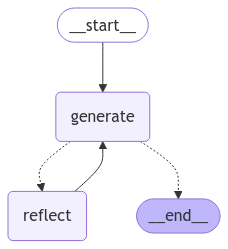

In [21]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Running the App

In [23]:
inputs = HumanMessage(content='Generate a tweet about FIFA World Cup 26')
response = graph.invoke(inputs)

In [24]:
for resp in response:
    display(Markdown(resp.content))
    print('\n' + '-' * 100 + '\n')

Generate a tweet about FIFA World Cup 26


----------------------------------------------------------------------------------------------------



🌍⚽️ The countdown to #FIFAWorldCup26 has officially begun! 🏆 With 48 teams and matches across the USA, Canada, and Mexico, this tournament is set to be the biggest celebration of global football yet! 🎉 Who are you rooting for? 🇺🇸🇨🇦🇲🇽 #WorldCup #FootballFever


----------------------------------------------------------------------------------------------------



Your tweet captures the excitement of the upcoming FIFA World Cup 2026 well! The emojis add a fun touch, and asking a question engages your audience effectively. Here are some suggestions to enhance its depth, style, and impact:

1. **Add a Unique Angle**: Instead of just announcing the size and locations, consider including a personal or unique perspective. For example, mention a memorable moment from past World Cups or speculate on which emerging teams might surprise us.

2. **Use a Stronger Hook**: Start with a more powerful statement. For instance, "Get ready to witness history at #FIFAWorldCup26!" This sets a more enthusiastic tone right from the beginning.

3. **Incorporate a Call to Action**: Encourage your followers to share their thoughts. For example, "Drop your predictions below! Who will make it to the finals?"

4. **Enhance Visual Appeal**: While emojis are great, consider using a GIF or an image related to previous World Cups or the host cities to make your tweet visually striking.

Here's a revised version of your tweet incorporating these suggestions:

"🔥 Get ready to witness history at #FIFAWorldCup26! 🌍🏆 With 48 teams and matches spanning the USA, Canada, and Mexico, this will be the biggest celebration of football yet! 🎉 Which underdog team do you think will steal the spotlight? Drop your predictions below! 🇺🇸🇨🇦🇲🇽 #FootballFever"

This version creates more excitement, prompts interaction, and maintains the engaging style of your original tweet!


----------------------------------------------------------------------------------------------------



🔥 Get ready to witness history at #FIFAWorldCup26! 🌍🏆 With 48 teams and matches spanning the USA, Canada, and Mexico, this will be the biggest celebration of football yet! 🎉 Which underdog team do you think will steal the spotlight? Drop your predictions below! 🇺🇸🇨🇦🇲🇽 #FootballFever


----------------------------------------------------------------------------------------------------



This is a fantastic tweet! You've effectively upped the enthusiasm and engagement factor. Here are a few final tweaks to consider that could further enhance its impact:

1. **Add a Personal Touch**: You might want to share a personal connection to the World Cup, such as a favorite memory or a reason why it matters to you. This can make your tweet feel more authentic and relatable.

2. **Highlight the Cultural Impact**: Mention the cultural significance of the tournament or how it brings nations together, which could deepen the emotional resonance of your tweet.

3. **Use a Hashtag Strategy**: In addition to #FootballFever, consider including a trending hashtag related to football or upcoming matches to increase visibility.

Here’s a refined version of your tweet:

"🔥 Get ready to witness history at #FIFAWorldCup26! 🌍🏆 With 48 teams competing across the USA, Canada, and Mexico, this will be the biggest celebration of football yet! 🎉 It’s a chance for underdogs to shine—who do you think will steal the spotlight? Share your predictions below! 🇺🇸🇨🇦🇲🇽 #FootballFever #WorldCupMagic"

This version maintains the excitement while also adding a touch of cultural importance and increasing its visibility potential! Great job overall—your audience will surely appreciate the energy and engagement!


----------------------------------------------------------------------------------------------------



🔥 Get ready to witness history at #FIFAWorldCup26! 🌍🏆 With 48 teams competing across the USA, Canada, and Mexico, this will be the biggest celebration of football yet! 🎉 It’s a chance for underdogs to shine—who do you think will steal the spotlight? Share your predictions below! 🇺🇸🇨🇦🇲🇽 #FootballFever #WorldCupMagic


----------------------------------------------------------------------------------------------------

